## Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [2]:
data = pd.read_csv("./dataset/Fertility.csv")
data.head(10)

,season,age,child_diseases,accident,surgical_intervention,high_fevers,alcohol,smoking,hrs_sitting,diagnosis
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O
5,-0.33,0.67,1,0,1,0,0.8,0,0.50,N
6,-0.33,0.67,0,0,0,-1,0.8,-1,0.44,N
7,-0.33,1.00,1,1,1,0,0.6,-1,0.38,N
8,1.00,0.64,0,0,1,0,0.8,-1,0.25,N
9,1.00,0.61,1,0,0,0,1.0,-1,0.25,N


## Basic EDA

,season,age,child_diseases,accident,surgical_intervention,high_fevers,alcohol,smoking,hrs_sitting,diagnosis
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,0
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,1
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,0
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,0
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,1
5,-0.33,0.67,1,0,1,0,0.8,0,0.50,0
6,-0.33,0.67,0,0,0,-1,0.8,-1,0.44,0
7,-0.33,1.00,1,1,1,0,0.6,-1,0.38,0
8,1.00,0.64,0,0,1,0,0.8,-1,0.25,0
9,1.00,0.61,1,0,0,0,1.0,-1,0.25,0


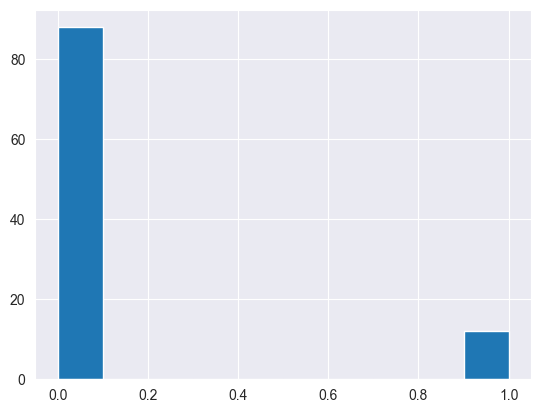

In [3]:
data['diagnosis'] = data['diagnosis'].map({'N': 0, 'O': 1})
data["diagnosis"].hist()
data.head(10)

<Axes: >

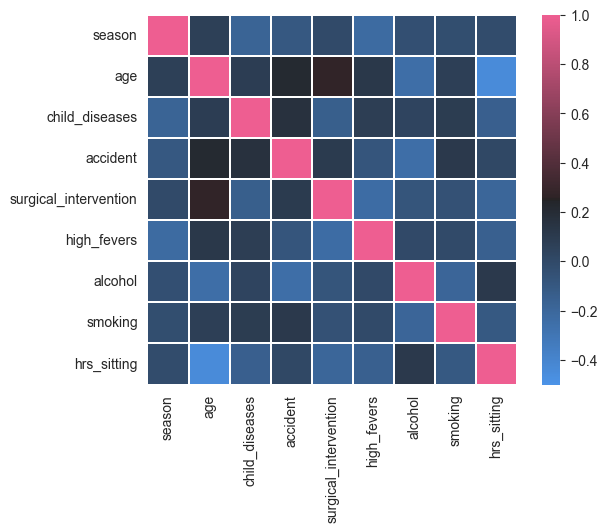

In [4]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
data = data[["age", "smoking", "diagnosis"]]
data.head(10)

,age,smoking,diagnosis
0,0.69,0,0
1,0.94,1,1
2,0.50,-1,0
3,0.75,-1,0
4,0.67,-1,1
5,0.67,0,0
6,0.67,-1,0
7,1.00,-1,0
8,0.64,-1,0
9,0.61,-1,0


<Axes: xlabel='smoking', ylabel='Count'>

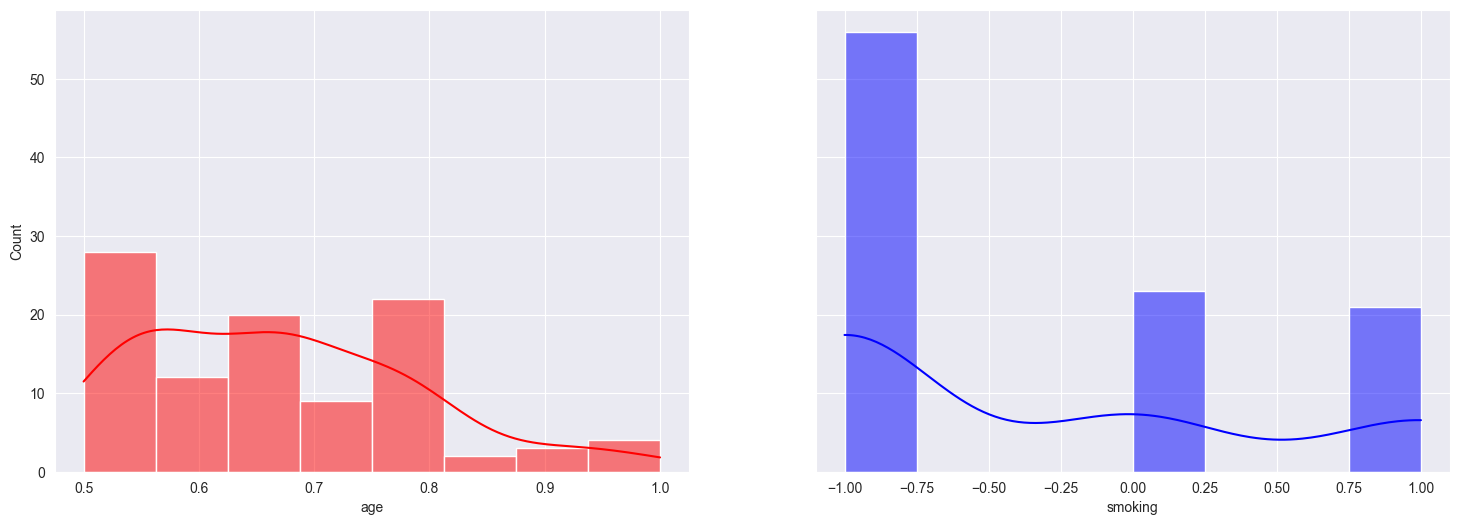

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="age", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="smoking", kde=True, color='b')

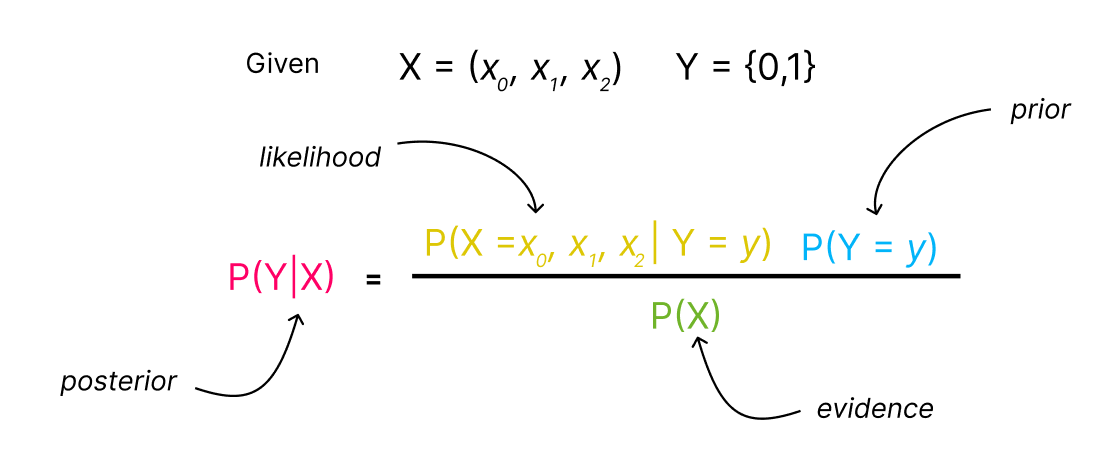

## Calculate P(Y=y) for all possible y

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [9]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [10]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Gaussian model

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Precision: ", precision_score(Y_test, Y_pred))
print("Recall: ", recall_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred))

Accuracy:  0.9
Confusion Matrix:
 [[18  0]
 [ 2  0]]
Precision:  0.0
Recall:  0.0
F1 Score: 0.0
ROC AUC Score: 0.5


d:\sshakya\covidproject\saroj\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Convert continuous features to Categorical features

In [12]:
data["cat_age"] = pd.cut(data["age"].values, bins = 3, labels = [0,1,2])
data["cat_smoking"] = pd.cut(data["smoking"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["age", "smoking"])
data = data[["cat_age",	"cat_smoking", "diagnosis"]]
data.head(10)

,cat_age,cat_smoking,diagnosis
0,1,1,0
1,2,2,1
2,0,0,0
3,1,0,0
4,1,0,1
5,1,1,0
6,1,0,0
7,2,0,0
8,0,0,0
9,0,0,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [13]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [14]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Categorical model

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Precision: ", precision_score(Y_test, Y_pred))
print("Recall: ", recall_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred))

Accuracy:  0.9
Confusion Matrix:
 [[18  0]
 [ 2  0]]
Precision:  0.0
Recall:  0.0
F1 Score: 0.0
ROC AUC Score: 0.5


d:\sshakya\covidproject\saroj\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
